**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
#%load_ext pycodestyle_magic

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re

import seaborn as sns
from sklearn import datasets
from scipy.spatial.distance import cdist
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

#%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [3]:
#%%pycodestyle

class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.Xtrain = X
        self.Ytrain = y
    
    def predict(self, X):
        if self.algorithm == 'brute':
            tmp = np.take_along_axis(
                np.tile(self.Ytrain, (X.shape[0], 1)), 
                np.argpartition(cdist(X, self.Xtrain),self.neighbors)[:, :self.neighbors],
                axis = 1)
            return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=tmp)
        if self.algorithm == 'kd_tree':
            kdt = KDTree(self.Xtrain, leaf_size=10, metric='euclidean')
            tmp = np.take_along_axis(
                                np.tile(self.Ytrain, (X.shape[0], 1)), 
                                kdt.query(X, k=self.neighbors, return_distance=False), 
                                axis=1)
            return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=tmp)
    
    def predict_proba(self, X):
        if self.algorithm == 'brute':
            minlength = np.unique(self.Ytrain).shape[0]
            tmp = np.take_along_axis(
                                np.tile(self.Ytrain, (X.shape[0], 1)), 
                                np.argpartition(cdist(X, self.Xtrain),self.neighbors)[:, :self.neighbors], 
                                axis=1)
            return np.apply_along_axis(
                                lambda x: (
                                        np.bincount(x, minlength=minlength) == 
                                        np.bincount(x, minlength=minlength).max(axis=-1, keepdims=True))/
                                        np.nonzero((
                                                np.bincount(x, minlength=minlength) == 
                                                np.bincount(x, minlength=minlength).max(
                                                                                    axis=-1, 
                                                                                    keepdims=True)))[0].shape[0],
                                axis=1, arr=tmp)
        if self.algorithm == 'kd_tree':
            kdt = KDTree(self.Xtrain, leaf_size=10, metric='euclidean')
            minlength = np.unique(self.Ytrain).shape[0]
            tmp = np.take_along_axis(
                                np.tile(self.Ytrain, (X.shape[0], 1)), 
                                kdt.query(X, k=self.neighbors, return_distance=False), axis=1)
            return np.apply_along_axis(
                                lambda x: (
                                        np.bincount(x, minlength=minlength) == 
                                        np.bincount(x, minlength=minlength).max(
                                                                            axis=-1, 
                                                                            keepdims=True))/
                                        np.nonzero((
                                                np.bincount(x, minlength=minlength) == 
                                                np.bincount(x, minlength=minlength).max(
                                                                                    axis=-1, 
                                                                                    keepdims=True)))[0].shape[0], 
                                axis=1, arr=tmp)
        
    def score(self, X, y):
        return (np.sum(self.predict(X) == y) / y.shape[0])

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 864 µs, sys: 91 µs, total: 955 µs
Wall time: 818 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.2 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 1.01 ms, sys: 108 µs, total: 1.11 ms
Wall time: 973 µs


array([2, 2, 1, 1, 0, 2, 0, 2, 2, 0, 1, 0, 0, 1, 2])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 673 µs, sys: 73 µs, total: 746 µs
Wall time: 527 µs


array([2, 2, 1, 1, 0, 2, 0, 2, 2, 0, 1, 0, 0, 1, 2])

In [13]:
%time clf.predict_proba(X_test)

CPU times: user 1.53 ms, sys: 167 µs, total: 1.7 ms
Wall time: 2.5 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [14]:
%time my_clf.predict_proba(X_test)

CPU times: user 3.19 ms, sys: 345 µs, total: 3.54 ms
Wall time: 2.84 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [15]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [17]:
%time clf.fit(X_train, y_train)

CPU times: user 857 µs, sys: 93 µs, total: 950 µs
Wall time: 980 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [18]:
%time my_clf.fit(X_train, y_train)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 9.54 µs


In [19]:
%time clf.predict(X_test)

CPU times: user 2.9 ms, sys: 0 ns, total: 2.9 ms
Wall time: 2.83 ms


array([2, 0, 1, 2, 1, 1, 0, 1, 0, 2, 0, 2, 0, 2, 1])

In [20]:
%time my_clf.predict(X_test)

CPU times: user 1.21 ms, sys: 129 µs, total: 1.34 ms
Wall time: 1.36 ms


array([2, 0, 1, 2, 1, 1, 0, 1, 0, 2, 0, 2, 0, 2, 1])

In [21]:
%time clf.predict_proba(X_test)

CPU times: user 2.96 ms, sys: 0 ns, total: 2.96 ms
Wall time: 2.64 ms


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [22]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.87 ms


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [23]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [24]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [25]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [26]:
data = [x.lower() for x in data]
data = [re.sub('[^0-9a-zA-Z]+', ' ', data) for data in data]
data = [data.split() for data in data]
data = [list(filter(None, x)) for x in data]
i = 0
target = list(target)
while i < len(data):
    if len(data[i]) == 0:
        target.pop(i)
        data.pop(i)
    else:
        i = i + 1
target = np.asarray(target)

In [27]:
data_tok = data #realize here
# data_tok should be a list of lists of tokens for each line in data.

In [28]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [29]:
# too big matrix -> memory error -> try to use small part of it
target = list(target)
data_tok = [x for i,x in enumerate(data_tok) if i % 7 == 0]
target = [x for i,x in enumerate(target) if i % 7 == 0]
target = np.asarray(target)

In [30]:
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

In [31]:
matr = csr_matrix((data, indices, indptr), dtype=int).toarray()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [32]:
clf = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')

In [33]:
cross_val_score(clf, matr, target, cv=3)

array([0.13207547, 0.10626186, 0.11650485])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [34]:
def mean_score_neighbors_relation1(matr, target, algorithm):
    result = []
    for i in range(1, 11):
        clf = KNeighborsClassifier(n_neighbors=i, algorithm=algorithm)
        result.append(cross_val_score(clf, matr, target, cv=3).mean())
    return result

Text(0.5, 0, 'neighbors')

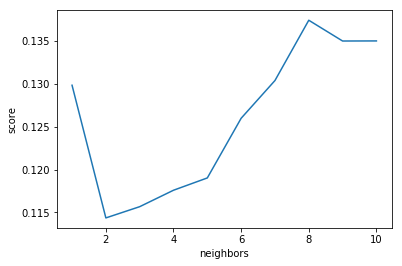

In [39]:
plt.plot(np.arange(1,11), mean_score_neighbors_relation1(matr, target, 'brute'))
plt.ylabel("score")
plt.xlabel('neighbors')

In [36]:
def mean_score_neighbors_relation2(matr, target, algorithm):
    result = []
    for i in range(1, 11):
        clf = KNeighborsClassifier(n_neighbors=i, algorithm=algorithm, metric='cosine')
        result.append(cross_val_score(clf, matr, target, cv=3).mean())
    return result

Text(0.5, 0, 'neghbors')

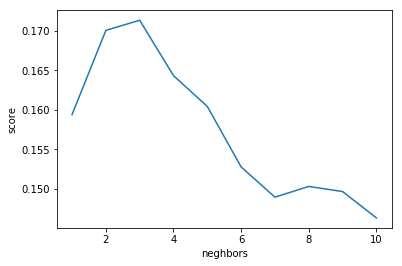

In [40]:
plt.plot(np.arange(1,11), mean_score_neighbors_relation2(matr, target, 'brute'))
plt.ylabel("score")
plt.xlabel("neghbors")

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [38]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.